In [1]:
import warnings
import os
from PIL import Image
import math
import numpy as np
import csv

import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import vgg19, VGG19_Weights, inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torchmetrics.functional import peak_signal_noise_ratio
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, UniPCMultistepScheduler

from scipy.linalg import sqrtm

from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.mps.is_available():
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
    device = torch.device("mps")


In [3]:
class SketchyDataset(Dataset):
    def __init__(self, image_dir, sketch_dir, photo_transform=None, sketch_transform=None,
                 use_bbox=False, stats_file='sketchy_dataset/info/stats.csv'):
        self.image_dir = image_dir
        self.sketch_dir = sketch_dir
        self.photo_transform = photo_transform
        self.sketch_transform = sketch_transform
        self.use_bbox = use_bbox

        # Load metadata from stats.csv for bounding boxes and invalid sketches
        self.bboxes = {}           # Maps photo ImageNetID to (left, top, right, bottom) for cropping
        self.invalid_sketches = set()  # Set of invalid sketch IDs (format: "ImageNetID-SketchID")&#8203;:contentReference[oaicite:3]{index=3}

        # Parse stats.csv to populate bboxes and invalid_sketches
        with open(stats_file, 'r') as csvfile:
            reader = csv.reader(csvfile)
            header = next(reader)  # skip header line
            for row in reader:
                # If a WorkerTag contains commas, merge extra columns into the last field
                if len(row) > 23:
                    row = row[:22] + [",".join(row[22:])]
                photo_id = row[2]    # e.g., "n02691156_11257"
                sketch_no = row[3]   # e.g., "1", "2", etc.
                # Check validity flags (Error, Context, Ambiguous, WrongPose)&#8203;:contentReference[oaicite:4]{index=4}
                if row[18] == '1' or row[19] == '1' or row[20] == '1' or row[21] == '1':
                    sketch_id = f"{photo_id}-{sketch_no}"
                    self.invalid_sketches.add(sketch_id)
                # Compute and store bounding box (scaled to 256x256) if needed
                if use_bbox and photo_id not in self.bboxes:
                    orig_w = float(row[12]); orig_h = float(row[13])
                    bx = float(row[14]); by = float(row[15]); bw = float(row[16]); bh = float(row[17])
                    # Scale bounding box to match the 256x256 resized photo dimensions&#8203;:contentReference[oaicite:5]{index=5}
                    scale_x = 256.0 / orig_w if orig_w > 0 else 1.0
                    scale_y = 256.0 / orig_h if orig_h > 0 else 1.0
                    left   = math.floor(bx * scale_x)
                    top    = math.floor(by * scale_y)
                    right  = math.ceil((bx + bw) * scale_x)
                    bottom = math.ceil((by + bh) * scale_y)
                    # Clamp to valid image bounds [0, 255]
                    right  = min(right, 255)
                    bottom = min(bottom, 255)
                    self.bboxes[photo_id] = (left, top, right, bottom)

        # Prepare list of sketch-photo pairs and compute per-category stats
        self.pairs = []
        self.photo_means = {}
        self.photo_stds  = {}
        self.sketch_means = {}
        self.sketch_stds  = {}
        categories = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
        categories_to_keep = []

        for category in categories:
            photo_dir = os.path.join(image_dir, category)
            sketch_dir_cat = os.path.join(sketch_dir, category)
            if not os.path.exists(photo_dir) or not os.path.exists(sketch_dir_cat):
                continue  # skip if either folder is missing
            # Initialize accumulators for this category
            photo_sum = np.zeros(3, dtype=np.float64)
            photo_sq_sum = np.zeros(3, dtype=np.float64)
            sketch_sum = np.zeros(3, dtype=np.float64)
            sketch_sq_sum = np.zeros(3, dtype=np.float64)
            photo_count = 0
            sketch_count = 0

            # Iterate over all photos in the category directory
            for photo_file in os.listdir(photo_dir):
                if not photo_file.lower().endswith(('.jpg', '.png')):
                    continue
                photo_id = os.path.splitext(photo_file)[0]
                # Use naming format to find matching sketches&#8203;:contentReference[oaicite:6]{index=6}
                # (If photo_id already contains a '-', it's a stable diffusion image corresponding to one sketch)
                prefix = photo_id + '-' if '-' not in photo_id else photo_id
                sketch_files = [f for f in os.listdir(sketch_dir_cat)
                                if f.lower().endswith(('.jpg', '.png')) and f.startswith(prefix)]
                # Filter out invalid sketches for this photo
                valid_sketches = [f for f in sketch_files if os.path.splitext(f)[0] not in self.invalid_sketches]
                if len(valid_sketches) == 0:
                    continue  # no valid sketches for this photo
                # Process this photo (since it has at least one valid sketch)
                photo_path = os.path.join(photo_dir, photo_file)
                # Accumulate photo pixel stats (in 0-1 range)
                img = Image.open(photo_path).convert('RGB')
                img_arr = np.array(img, dtype=np.float32) / 255.0
                photo_sum    += img_arr.sum(axis=(0, 1))
                photo_sq_sum += (img_arr ** 2).sum(axis=(0, 1))
                photo_count  += 1
                # Process each valid sketch for this photo
                for sketch_file in valid_sketches:
                    sketch_path = os.path.join(sketch_dir_cat, sketch_file)
                    sk_img = Image.open(sketch_path).convert('RGB')
                    sk_arr = np.array(sk_img, dtype=np.float32) / 255.0
                    sketch_sum    += sk_arr.sum(axis=(0, 1))
                    sketch_sq_sum += (sk_arr ** 2).sum(axis=(0, 1))
                    sketch_count  += 1
                    # Store the valid pair
                    self.pairs.append({
                        'category': category,
                        'photo': photo_path,
                        'sketch': sketch_path
                    })
            # Compute mean and std for this category (if any valid pairs exist)
            if photo_count > 0 and sketch_count > 0:
                # Mean per channel
                photo_mean = photo_sum / (photo_count * 256 * 256)
                sketch_mean = sketch_sum / (sketch_count * 256 * 256)
                # Variance per channel
                photo_var = (photo_sq_sum / (photo_count * 256 * 256)) - (photo_mean ** 2)
                sketch_var = (sketch_sq_sum / (sketch_count * 256 * 256)) - (sketch_mean ** 2)
                photo_var = np.clip(photo_var, 0, None)   # avoid negative due to floating error
                sketch_var = np.clip(sketch_var, 0, None)
                photo_std = np.sqrt(photo_var)
                sketch_std = np.sqrt(sketch_var)
                # Store stats (as Python lists for later normalization)
                self.photo_means[category]  = photo_mean.tolist()
                self.photo_stds[category]   = photo_std.tolist()
                self.sketch_means[category] = sketch_mean.tolist()
                self.sketch_stds[category]  = sketch_std.tolist()
                categories_to_keep.append(category)
        # Keep only categories that have valid pairs
        self.categories = categories_to_keep

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        category = pair['category']
        # Load images
        photo = Image.open(pair['photo']).convert('RGB')
        sketch = Image.open(pair['sketch']).convert('RGB')
        # Crop photo to bounding box if enabled (only for original photos)
        if self.use_bbox:
            photo_id = os.path.splitext(os.path.basename(pair['photo']))[0]
            if photo_id in self.bboxes:
                left, top, right, bottom = self.bboxes[photo_id]
                photo = photo.crop((left, top, right, bottom))
                # Resize back to 256x256 to maintain consistent dimensions
                photo = photo.resize((256, 256), Image.BILINEAR)
        # Apply any additional (non-normalization) transforms
        if self.photo_transform:
            photo = self.photo_transform(photo)
        if self.sketch_transform:
            sketch = self.sketch_transform(sketch)
        # Convert to tensor if not already
        if not isinstance(photo, torch.Tensor):
            photo = transforms.functional.to_tensor(photo)
        if not isinstance(sketch, torch.Tensor):
            sketch = transforms.functional.to_tensor(sketch)
        # Normalize using the precomputed mean and std for this category
        if category in self.photo_means and category in self.photo_stds:
            photo = transforms.functional.normalize(photo, mean=self.photo_means[category], std=self.photo_stds[category])
        if category in self.sketch_means and category in self.sketch_stds:
            sketch = transforms.functional.normalize(sketch, mean=self.sketch_means[category], std=self.sketch_stds[category])
        return {
            'sketch': sketch.clamp(0, 1),
            'photo': photo.clamp(0, 1),
            'category': category,
            'sketch_path': pair['sketch'],
            'photo_path': pair['photo']
        }


In [4]:
dataset = SketchyDataset(
    image_dir='sketchy_dataset/photo/tx_000000000000',
    sketch_dir='sketchy_dataset/sketch/tx_000000000000',
    use_bbox=True
)


In [5]:
train_subset, val_subset = random_split(dataset, [len(dataset) - 500, 500], generator=torch.Generator().manual_seed(42))
dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)


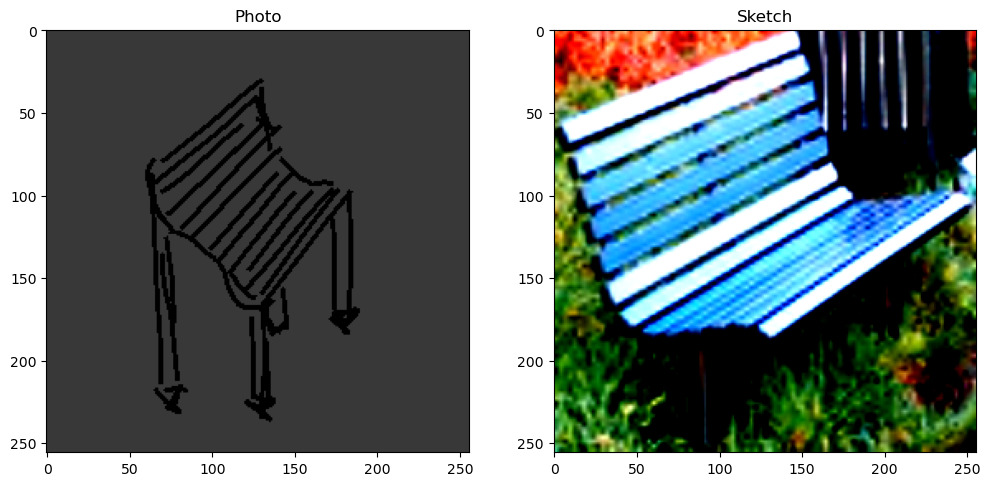

In [6]:
# Fetch the first batch
batch = next(iter(dataloader))

# Display a sample photo and its corresponding sketch
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Access the first photo and sketch in the batch
photo = batch['photo'][0].permute(1, 2, 0).numpy()  # Display photo
sketch = batch['sketch'][0].permute(1, 2, 0).numpy()  # Display sketch

# Plotting the photo and sketch side-by-side
ax[0].imshow(sketch)
ax[0].set_title("Photo")

ax[1].imshow(photo)
ax[1].set_title("Sketch")

plt.show()


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder: Downsample
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Decoder: Upsample
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        return self.decoder(x1)


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # PatchGAN: Classifies patches of the image as real or fake
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Output a single value (real/fake)
        )

    def forward(self, x):
        return self.model(x)


In [9]:
class GANLoss(nn.Module):
    def __init__(self, gan_type='bce'):
        super(GANLoss, self).__init__()
        if gan_type == 'bce':
            self.criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss

    def forward(self, logits, target):
        return self.criterion(logits, target)


In [10]:
class PerceptualLoss(nn.Module):
    def __init__(self, model):
        super(PerceptualLoss, self).__init__()
        self.model = model.features.to(device).eval()

    def forward(self, generated, real):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        generated_features = self.model(normalize(generated))
        real_features = self.model(normalize(real))
        return F.mse_loss(generated_features, real_features)


In [11]:
warnings.filterwarnings(
    "ignore",
    message="Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated",
    category=FutureWarning
)

def compute_psnr(generated, real):
    psnr_total = 0.0
    for p, t in zip(generated, real):
        psnr_total += peak_signal_noise_ratio(p, t, data_range=1.0)
    return psnr_total / len(generated)


# def compute_psnr(generated, real):
#     psnr_total = 0
#     for g, r in zip(generated, real):
#         mse = F.mse_loss(g, r)
#         if mse == 0:
#             psnr = 100  # max possible
#         else:
#             psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
#         psnr_total += psnr
#     return psnr_total / len(generated)


In [12]:
def compute_ssim(generated, real, win_size=7):
    """
    generated, reference: torch.Tensor of shape [B, 3, H, W] in [0, 1]
    """
    ssim_total = 0.0
    for g, r in zip(generated, real):
        g_np = g.cpu().numpy().transpose(1, 2, 0)
        r_np = r.cpu().numpy().transpose(1, 2, 0)
        ssim_total += ssim(
        g_np,
        r_np,
        win_size=win_size,
        channel_axis=2,
        data_range=1.0
    )
    return ssim_total / len(generated)


In [13]:
warnings.filterwarnings(
    "ignore",
    "NOTE: The nodes obtained by tracing the model in eval mode are a subsequence"
)

# 1) Build a feature-extractor that returns the 2048-d avgpool output
def get_inception_extractor():
    inception = inception_v3(weights=Inception_V3_Weights.DEFAULT).to(device)
    inception.eval()
    return create_feature_extractor(
        inception,
        return_nodes={'avgpool': 'feat'},
    )

# 2) Extract features from a batch of tensors [N,3,256,256] in [-1,1]
def extract_features(x, extractor):
    if not isinstance(x, torch.Tensor):
        x = torch.stack([img.clone().detach() for img in x])

    x = x.float()

    # x: [N,3,256,256] in [-1,1]
    x = (x * 0.5) + 0.5
    x = F.interpolate(x, size=(299,299), mode='bilinear', align_corners=False)
    mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
    x = (x - mean) / std

    with torch.no_grad():
        out = extractor(x)['feat']  # [N,2048,1,1]
    return out.view(out.size(0), -1).cpu().numpy()  # [N,2048]

# 3) Compute FID from two batches of images
def compute_fid(real_images, generated_images):
    # Build extractor once
    extractor = get_inception_extractor()

    if not isinstance(real_images, torch.Tensor):
        real_images = torch.stack([img.clone().detach() for img in real_images])
    if not isinstance(generated_images, torch.Tensor):
        generated_images = torch.stack([img.clone().detach() for img in generated_images])

    real_feats = extract_features(real_images, extractor)
    fake_feats = extract_features(generated_images, extractor)

    mu_r, mu_f = real_feats.mean(0), fake_feats.mean(0)
    sigma_r = np.cov(real_feats, rowvar=False)
    sigma_f = np.cov(fake_feats, rowvar=False)

    diff = mu_r - mu_f
    covmean, _ = sqrtm(sigma_r.dot(sigma_f), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_r + sigma_f - 2 * covmean)
    return float(fid)


In [14]:
def init():
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    gan_loss = GANLoss().to(device)
    perceptual_loss = PerceptualLoss(vgg19(weights=VGG19_Weights.DEFAULT)).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    return generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D


In [15]:
num_epochs = 50  # Set the number of epochs you want to train for
output_height = output_width = 255 // 16


In [16]:
def train(generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D, num_epochs=50, steps=10, adv=1, l1=100, perc=0.02):
    for epoch in range(num_epochs):
        for i, batch in enumerate(dataloader):
            sketches = batch['sketch'].to(device)
            photos = batch['photo'].to(device)

            # Train Discriminator
            optimizer_D.zero_grad()

            real_labels = torch.ones(sketches.size(0), 1, output_height, output_width).to(device)
            fake_labels = torch.zeros(sketches.size(0), 1, output_height, output_width).to(device)

            # Real images
            real_output = discriminator(torch.cat((sketches, photos), 1))
            d_loss_real = gan_loss(real_output, real_labels)

            # Fake images
            fake_photos = generator(sketches)
            fake_output = discriminator(torch.cat((sketches, fake_photos.detach()), 1))
            d_loss_fake = gan_loss(fake_output, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            fake_output = discriminator(torch.cat((sketches, fake_photos), 1))
            g_loss = adv * gan_loss(fake_output, real_labels) + l1 * F.l1_loss(fake_photos, photos) + perc * perceptual_loss(fake_photos, photos)

            g_loss.backward()
            optimizer_G.step()

        # Print and save model checkpoints
        print(f'Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

        # Monitor training progress: Visualize generated images and calculate metrics
        if epoch == 0 or (epoch + 1) % steps == 0:
            torch.save(generator.state_dict(), f"generator_epoch_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch}.pth")

            with torch.no_grad():
                generated_images = generator(sketches)
                # Denormalize if needed
                generated_images = generated_images * 0.5 + 0.5
                photos = photos * 0.5 + 0.5

            psnr_value = compute_psnr(generated_images, photos)
            ssim_value = compute_ssim(generated_images[0:1], photos[0:1])
            fid_value = compute_fid(photos, generated_images)

            print(f'Epoch [{epoch + 1}/{num_epochs}], PSNR: {psnr_value.item()}, SSIM: {ssim_value}, FID: {fid_value}')

            # Plot real vs generated images
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(photos[0].cpu().permute(1, 2, 0).numpy())
            ax[0].set_title("Real Photo")
            ax[1].imshow(generated_images[0].cpu().permute(1, 2, 0).numpy())
            ax[1].set_title("Generated Photo")
            plt.show()


In [17]:
# for loss_perc in [0.05, 0.08, 0.10, 0.12]:
#     for loss_L1 in [100, 75, 50, 25]:
#         generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D = init()
#         train(generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D, num_epochs=10, steps=10, adv=1.0, l1=loss_L1, perc=loss_perc)


In [ ]:
generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D = init()
train(generator, discriminator, gan_loss, perceptual_loss, optimizer_G, optimizer_D, num_epochs=num_epochs, l1=50, perc=0.1)


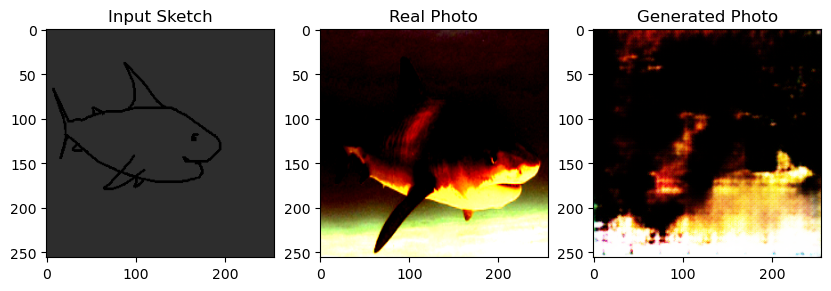

In [23]:
# Fetch a sample from the validation set
sample = next(iter(dataloader))

# Generate fake images
generated_images = generator(sample['sketch'].to(device))

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample['sketch'][0].permute(1, 2, 0).numpy())
plt.title("Input Sketch")
plt.subplot(1, 3, 2)
plt.imshow(sample['photo'][0].permute(1, 2, 0).numpy())
plt.title("Real Photo")
plt.subplot(1, 3, 3)
plt.imshow(generated_images[0].clamp(0, 1).cpu().permute(1, 2, 0).detach().numpy())
plt.title("Generated Photo")
plt.show()


In [49]:
class StableDiffusionScribble:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        controlnet = ControlNetModel.from_pretrained(
            "lllyasviel/sd-controlnet-scribble",
            torch_dtype=torch.float16 if self.device == "cuda" else torch.float32
        )

        self.pipe = StableDiffusionControlNetPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            controlnet=controlnet,
            torch_dtype=torch.float16 if self.device == "cuda" else torch.float32
        )
        self.pipe.scheduler = UniPCMultistepScheduler.from_config(self.pipe.scheduler.config)
        self.pipe.to(self.device)

        if self.device == "cuda":
            self.pipe.enable_xformers_memory_efficient_attention()

        self.resize = transforms.Resize((256, 256), interpolation=Image.BILINEAR)

    def generate(self, sketch_tensor, prompt="a photo of this object"):
        """
        Args:
            sketch_tensor (Tensor): shape [3, 256, 256], assumed in [-1, 1] or normalized
            prompt (str): Text description to guide SD (optional)

        Returns:
            Tensor: SD-generated photo image, shape [3, 256, 256], in [0, 1]
        """
        # Convert tensor to PIL image (denormalize first if needed)
        sketch_tensor = sketch_tensor.detach().cpu()
        if sketch_tensor.min() < 0:
            sketch_tensor = sketch_tensor * 0.5 + 0.5
        sketch_img = transforms.ToPILImage()(sketch_tensor)
        sketch_img = sketch_img.convert("RGB")
        sketch_img = self.resize(sketch_img)

        result = self.pipe(prompt=prompt, image=sketch_img, num_inference_steps=20)
        image = result.images[0]

        # Convert back to tensor in [0, 1]
        image_tensor = transforms.ToTensor()(image)
        return image_tensor


In [50]:
sd_generator = StableDiffusionScribble()

# Instantiate Pix2Pix generator and load trained weights
pix2pix_generator = Generator()
pix2pix_generator.load_state_dict(torch.load(f"generator_epoch_{num_epochs - 1}.pth", weights_only=True))
pix2pix_generator.eval()
pix2pix_generator.to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13)

In [51]:
# Store results
sd_outputs = []
pix2pix_outputs = []
real_photos = []
val_sketches = []

# Evaluate
with torch.no_grad():
    for batch in val_loader:
        sketches = batch['sketch'].to(device)
        photos = batch['photo'].to(device)

        # Pix2Pix
        pred_pix2pix = pix2pix_generator(sketches)

        # SD (one-by-one for memory and CPU-bound inference)
        pred_sd = []
        for i, sketch in enumerate(sketches):
            img = sd_generator.generate(sketch, prompt = f"a photo of a {batch['category'][i].replace('_', ' ')}"
)
            pred_sd.append(img)
        pred_sd = torch.stack(pred_sd).to(device)

        # Save outputs for metric computation
        sd_outputs.append(pred_sd)
        pix2pix_outputs.append(pred_pix2pix)
        real_photos.append(photos)
        val_sketches.append(sketches)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [52]:
# Stack all batches(this part should only be run once)
sd_outputs = torch.cat(sd_outputs)
pix2pix_outputs = torch.cat(pix2pix_outputs)
real_photos = torch.cat(real_photos)
val_sketches = torch.cat(val_sketches)

sd_outputs = [sd_output.clamp(0, 1) for sd_output in sd_outputs]
pix2pix_outputs = [pix2pix_output.clamp(0, 1) for pix2pix_output in pix2pix_outputs]
real_photos = [real_photo.clamp(0, 1) for real_photo in real_photos]
val_sketches = [val_sketch.clamp(0, 1) for val_sketch in val_sketches]


In [53]:
# Compute metrics
print("--- Evaluation Metrics ---")
print("SD:")
print("  PSNR:", compute_psnr(sd_outputs, real_photos).cpu().numpy())
print("  SSIM:", compute_ssim(sd_outputs, real_photos))
print("  FID: ", compute_fid(real_photos, sd_outputs))

print("Pix2Pix:")
print("  PSNR:", float(compute_psnr(pix2pix_outputs, real_photos)))
print("  SSIM:", compute_ssim(pix2pix_outputs, real_photos))
print("  FID: ", compute_fid(real_photos, pix2pix_outputs))


--- Evaluation Metrics ---
SD:
  PSNR: 5.332502841949463
  SSIM: 0.13986285
  FID:  270.6709960701943
Pix2Pix:
  PSNR: 6.337498664855957
  SSIM: 0.13216493
  FID:  304.2154483698645


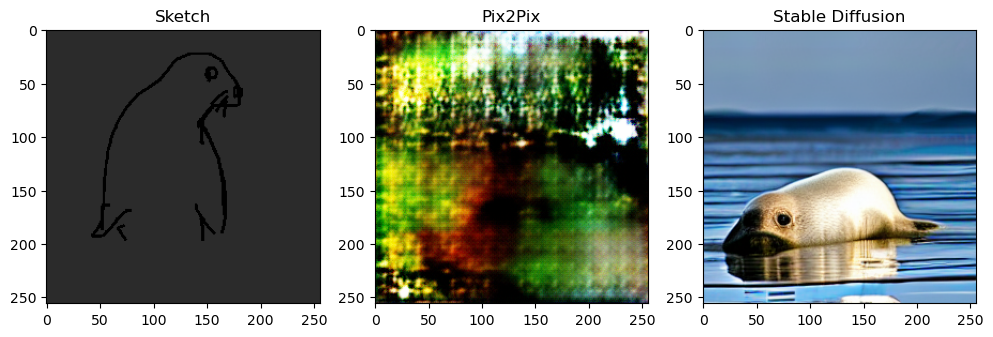

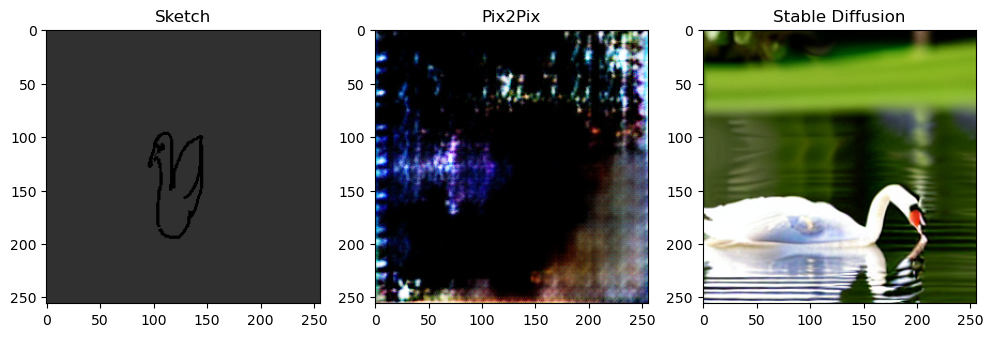

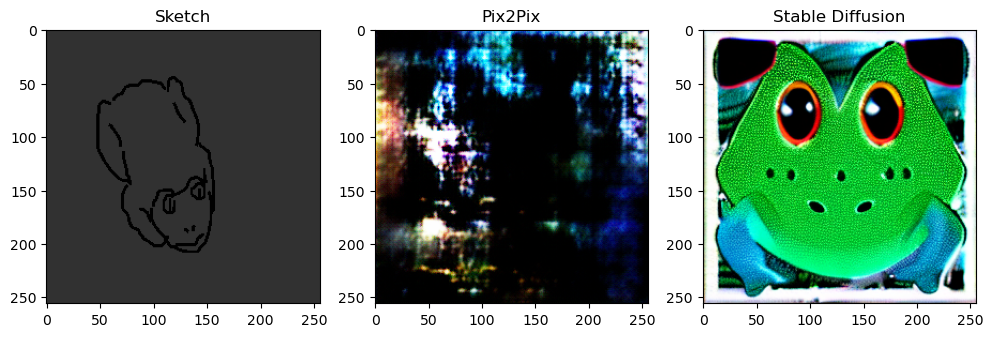

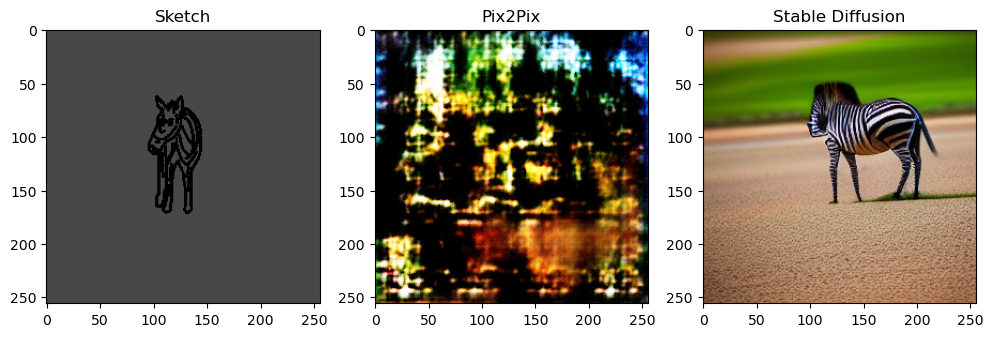

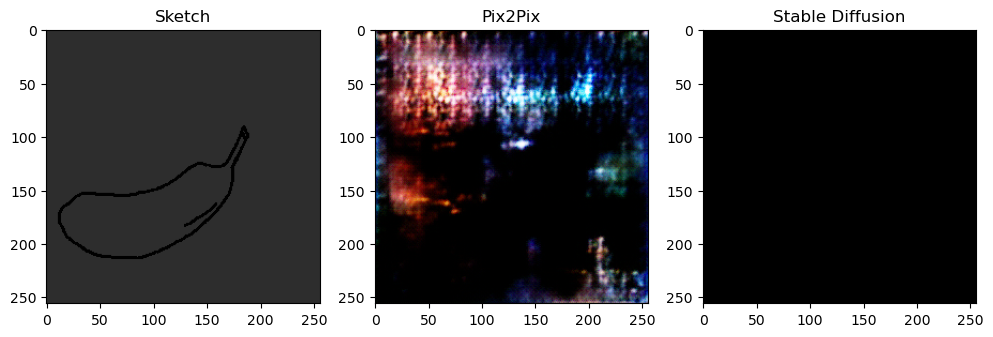

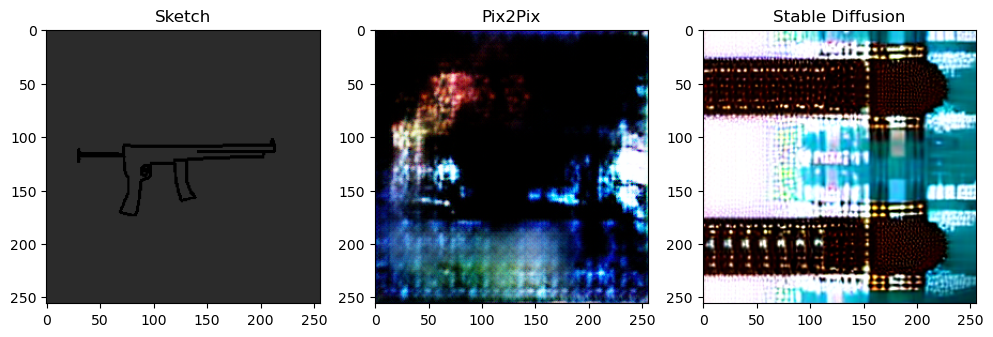

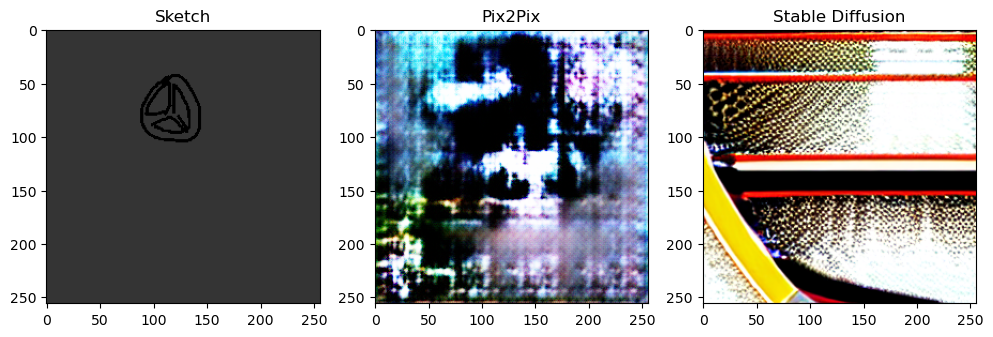

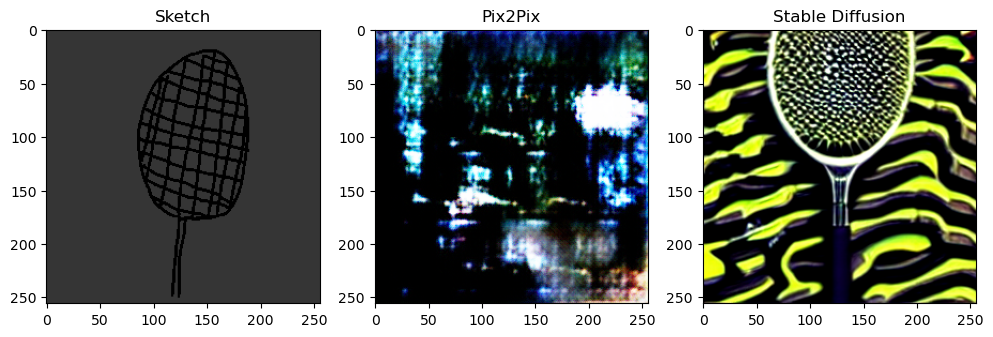

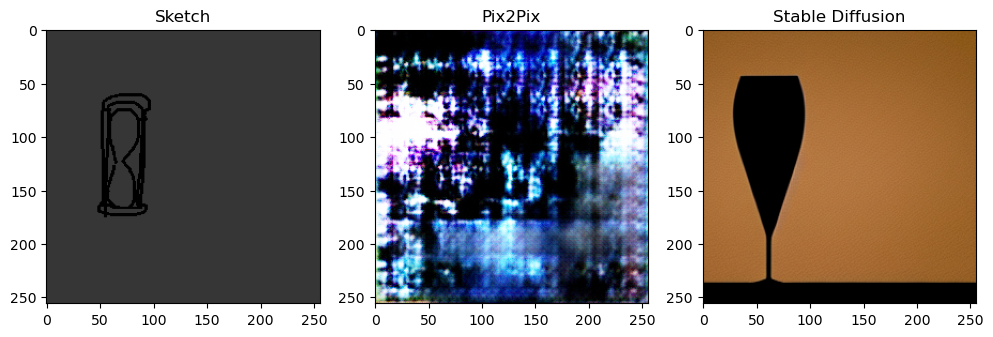

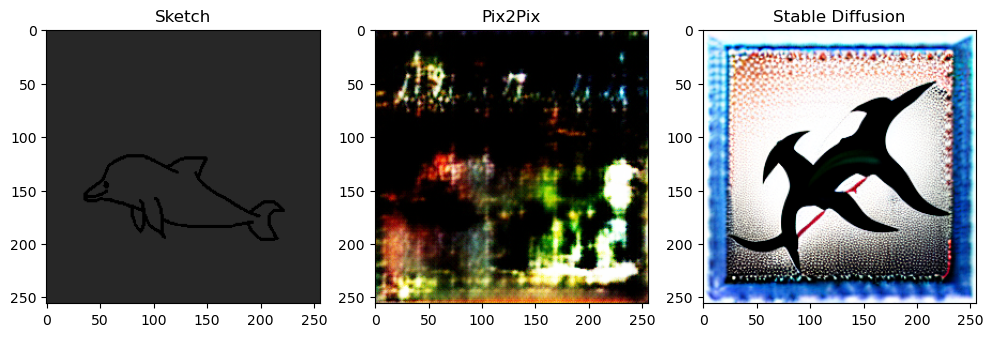

In [54]:
# Visual comparison
for i in range(10):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(val_sketches[i].cpu().permute(1, 2, 0))
    axs[0].set_title("Sketch")
    axs[1].imshow(pix2pix_outputs[i].cpu().permute(1, 2, 0))
    axs[1].set_title("Pix2Pix")
    axs[2].imshow(sd_outputs[i].cpu().permute(1, 2, 0))
    axs[2].set_title("Stable Diffusion")
    plt.show()


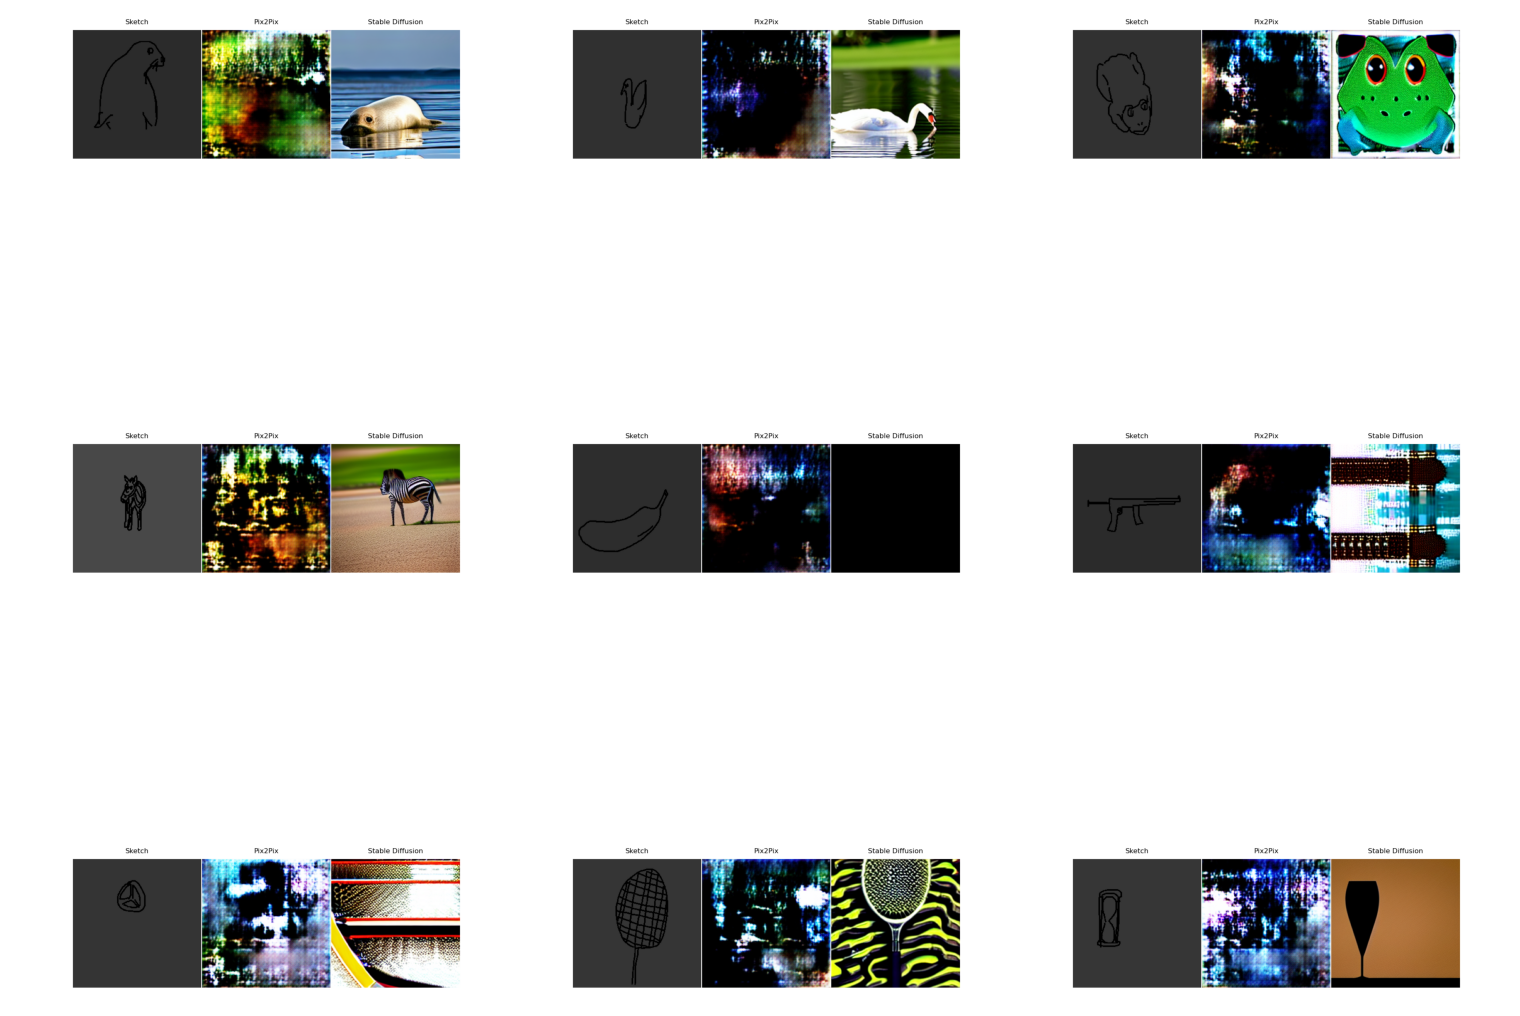

In [59]:
# 创建3x3的紧凑九宫格布局
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
plt.subplots_adjust(wspace=0, hspace=0)  # 移除子图之间的间距

# 展示9张图片的比较
for i in range(9):
    row = i // 3
    col = i % 3

    # 创建一个子图用于显示三张图片的比较
    comparison_fig = plt.figure(figsize=(12, 4))
    plt.subplots_adjust(wspace=0, hspace=0)  # 移除比较图中的间距

    # 显示素描
    plt.subplot(1, 3, 1)
    plt.imshow(val_sketches[i].cpu().permute(1, 2, 0))
    plt.title("Sketch", pad=10)  # 调整标题与图片的距离
    plt.axis('off')

    # 显示Pix2Pix结果
    plt.subplot(1, 3, 2)
    plt.imshow(pix2pix_outputs[i].cpu().permute(1, 2, 0))
    plt.title("Pix2Pix", pad=10)
    plt.axis('off')

    # 显示Stable Diffusion结果
    plt.subplot(1, 3, 3)
    plt.imshow(sd_outputs[i].cpu().permute(1, 2, 0))
    plt.title("Stable Diffusion", pad=10)
    plt.axis('off')

    # 将比较图添加到九宫格中
    comparison_fig.canvas.draw()  # 确保图形已经被渲染
    # 修改后的代码
    img_data = np.frombuffer(comparison_fig.canvas.buffer_rgba(), dtype=np.uint8)
    img_data = img_data.reshape(comparison_fig.canvas.get_width_height()[::-1] + (4,))  # 注意这里是4通道

    img_data = img_data[:,:,:3]

    axs[row, col].imshow(img_data)
    axs[row, col].axis('off')
    plt.close(comparison_fig)

# 调整整体布局
plt.tight_layout(pad=0)  # 移除外边距
plt.show()

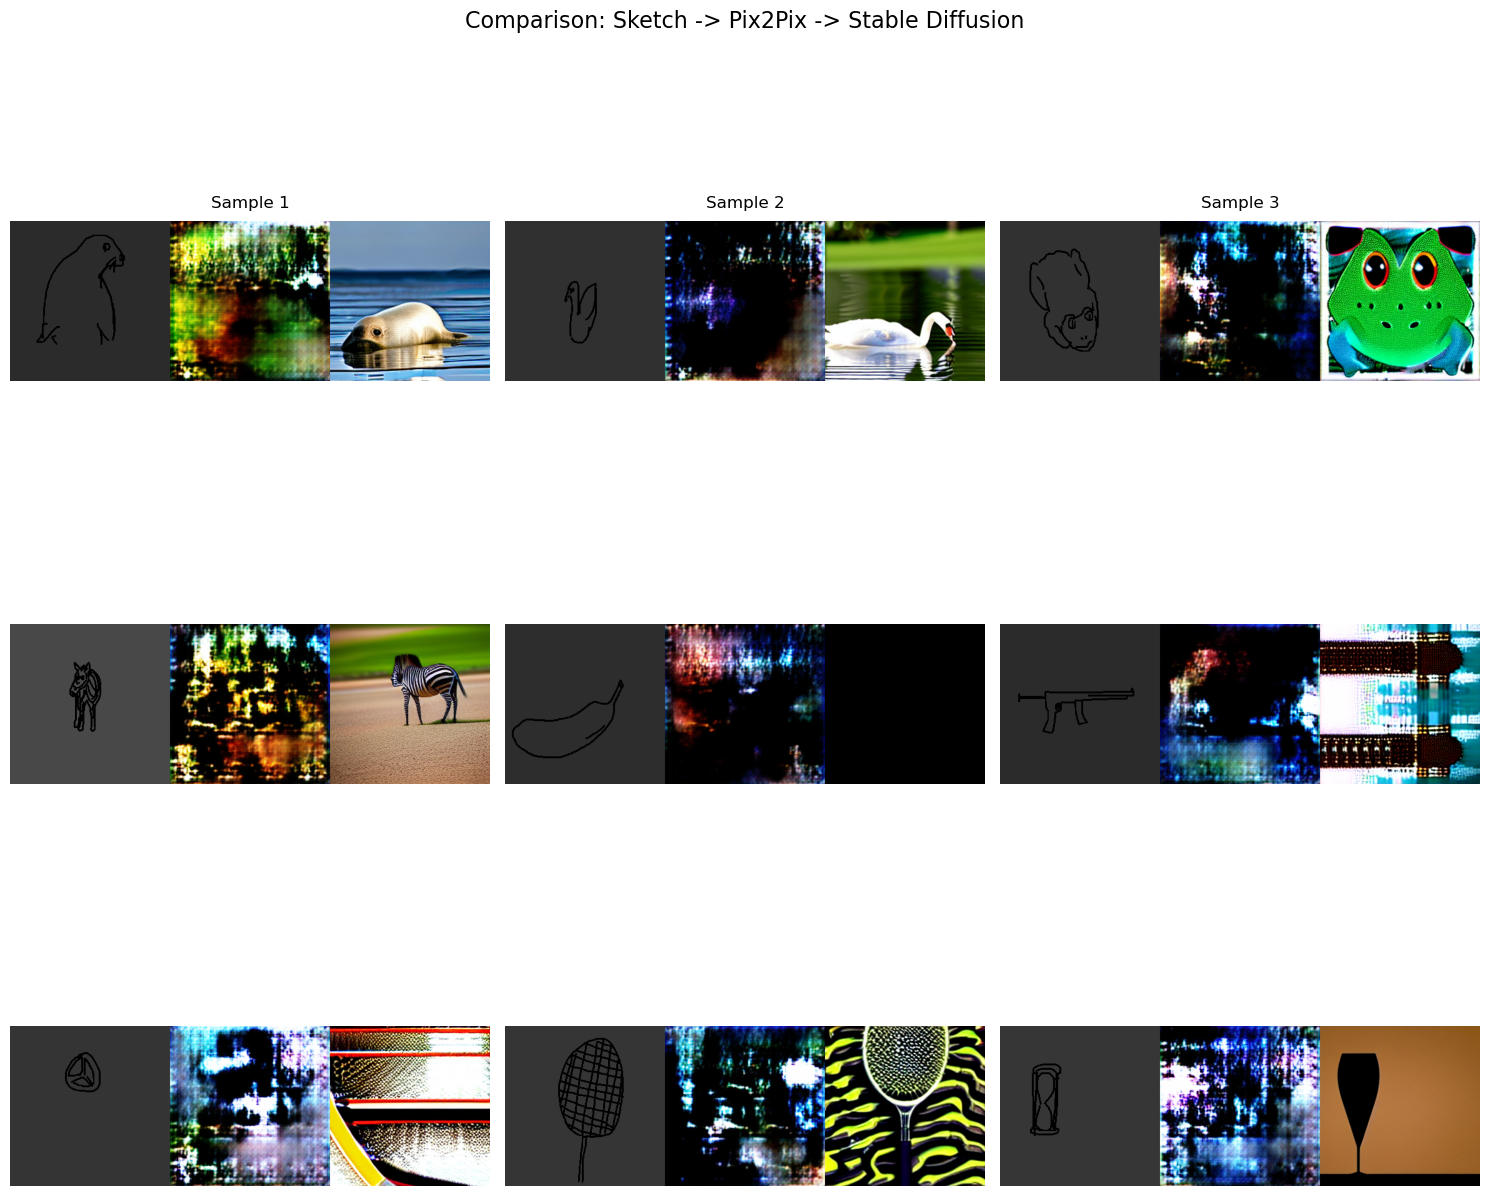

In [60]:
# 创建3x3的紧凑九宫格布局
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # 添加少量间距以提高可读性

# 展示9张图片的比较
for i in range(9):
    row = i // 3
    col = i % 3

    # 在同一个子图中创建三列
    sketch = val_sketches[i].cpu().permute(1, 2, 0).numpy()
    pix2pix = pix2pix_outputs[i].cpu().permute(1, 2, 0).numpy()
    sd = sd_outputs[i].cpu().permute(1, 2, 0).numpy()

    # 水平拼接三张图片
    combined = np.hstack([sketch, pix2pix, sd])

    # 显示在九宫格中
    axs[row, col].imshow(combined)
    axs[row, col].axis('off')

    # 为第一行添加标题
    if row == 0:
        axs[row, col].set_title(f'Sample {i+1}', pad=10)

# 添加总标题
plt.suptitle('Comparison: Sketch -> Pix2Pix -> Stable Diffusion', fontsize=16, y=0.95)

# 调整整体布局
plt.tight_layout()
plt.show()

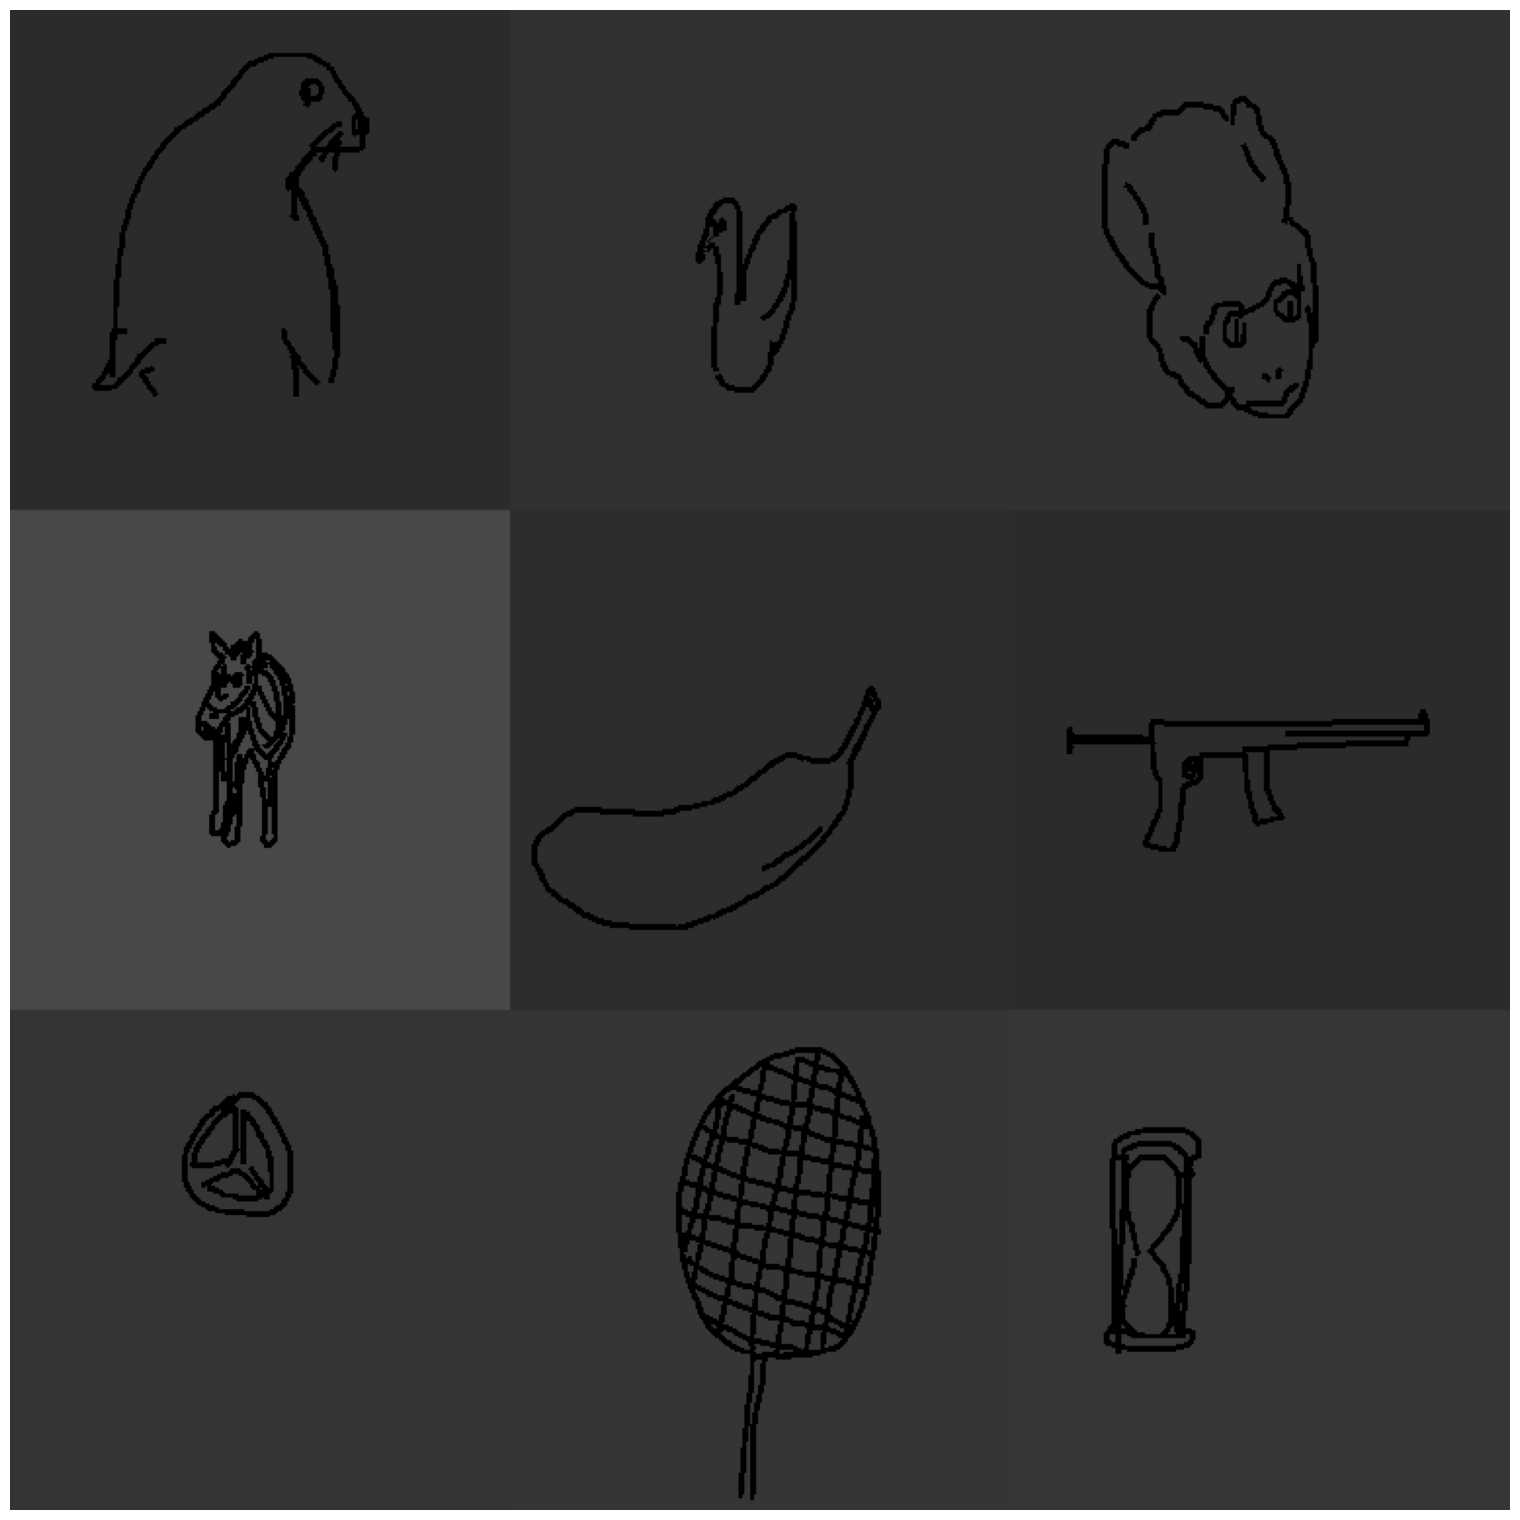

In [61]:
# 创建一个大图来容纳所有图片
fig = plt.figure(figsize=(15, 15))

# 计算网格布局
n_rows = 3
n_cols = 3
grid_height = n_rows * 256  # 假设每张图片高度为256
grid_width = n_cols * 256   # 假设每张图片宽度为256

# 创建一个大的画布来存放所有图片
full_grid = np.zeros((grid_height, grid_width, 3))

# 填充网格
for i in range(9):
    row = i // 3
    col = i % 3

    # 获取当前样本的图片
    sketch = val_sketches[i].cpu().permute(1, 2, 0).numpy()

    # 计算在大网格中的位置
    row_start = row * 256
    row_end = (row + 1) * 256
    col_start = col * 256
    col_end = (col + 1) * 256

    # 将图片放入大网格中
    full_grid[row_start:row_end, col_start:col_end] = sketch

# 显示完整的网格
plt.imshow(full_grid)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

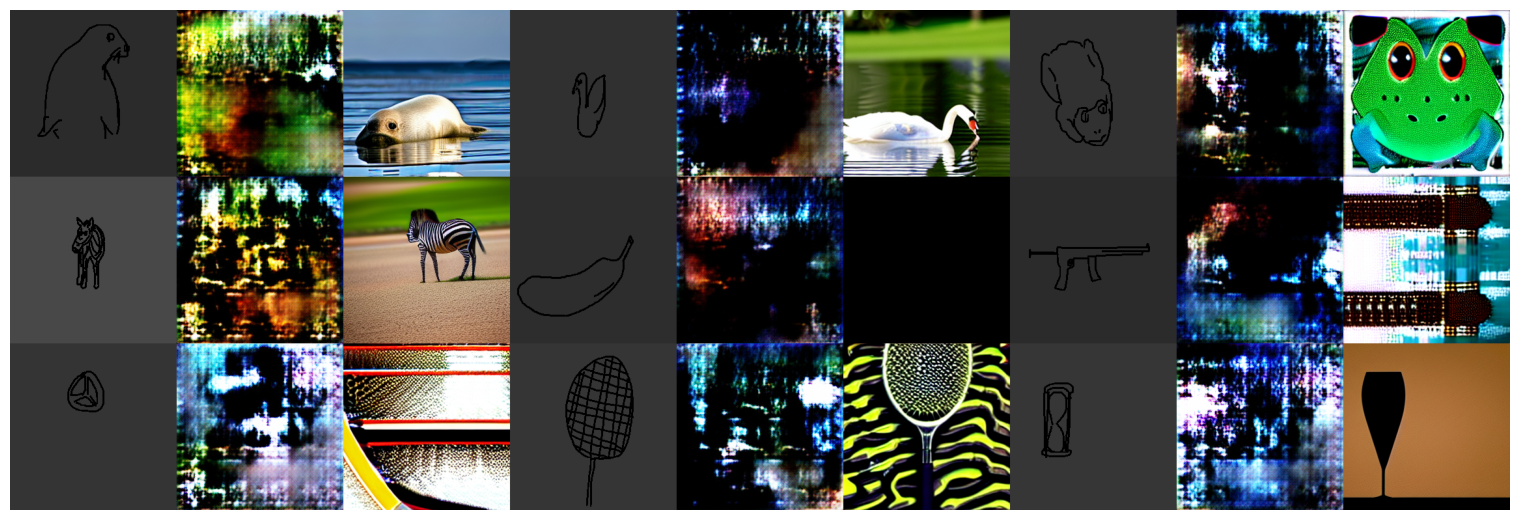

In [62]:
# 创建一个大图来容纳所有图片
fig = plt.figure(figsize=(15, 15))

# 计算网格布局
n_rows = 3
n_cols = 3
sample_width = 256 * 3  # 每个样本包含3张图片
grid_height = n_rows * 256
grid_width = n_cols * sample_width

# 创建一个大的画布来存放所有图片
full_grid = np.zeros((grid_height, grid_width, 3))

# 填充网格
for i in range(9):
    row = i // 3
    col = i % 3

    # 获取当前样本的三张图片
    sketch = val_sketches[i].cpu().permute(1, 2, 0).numpy()
    pix2pix = pix2pix_outputs[i].cpu().permute(1, 2, 0).numpy()
    sd = sd_outputs[i].cpu().permute(1, 2, 0).numpy()

    # 计算在大网格中的位置
    row_start = row * 256
    row_end = (row + 1) * 256
    col_start = col * sample_width

    # 将三张图片依次放入大网格中
    full_grid[row_start:row_end, col_start:col_start+256] = sketch
    full_grid[row_start:row_end, col_start+256:col_start+512] = pix2pix
    full_grid[row_start:row_end, col_start+512:col_start+768] = sd

# 显示完整的网格
plt.imshow(full_grid)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()